In [20]:
import cv2
import os

import matplotlib.pyplot as plt

from torchvision.transforms import transforms, Compose
import torch.nn as nn

import numpy as np
import math

import torch

In [21]:
H_LO = 16
H_HI = 640
W_LO = 16
W_HI = 640

class ScaleToImageSize:
    def __init__(self, patch_size: int, w_lo: int = W_LO, w_hi: int = W_HI, h_lo: int = H_LO, h_hi: int = H_HI, ) -> None:
        assert w_lo <= w_hi and h_lo <= h_hi
        self.w_lo = w_lo
        self.w_hi = w_hi
        self.h_lo = h_lo
        self.h_hi = h_hi
        self.patch_size = patch_size
    
    def __call__(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]
        r = h / w
        lo_r = self.h_lo / self.w_hi
        hi_r = self.h_hi / self.w_lo
        assert lo_r <= h / w <= hi_r, f"img ratio h:w {r} not in range [{lo_r}, {hi_r}]"

        scale_r = min(self.h_hi / h, self.w_hi / w)
        if scale_r < 1.0:
            # one of h or w highr that hi, so scale down
            img = cv2.resize(img, None, fx=scale_r, fy=scale_r, interpolation=cv2.INTER_CUBIC)
            return img

        scale_r = max(self.h_lo / h, self.w_lo / w)
        if scale_r > 1.0:
            # one of h or w lower that lo, so scale up
            img = cv2.resize(img, None, fx=scale_r, fy=scale_r, interpolation=cv2.INTER_CUBIC)
            return img
        
        # in the rectangle, do not scale
        assert self.h_lo <= h <= self.h_hi and self.w_lo <= w <= self.w_hi
        
        new_h, new_w = img.shape[:2]
        
        print(new_w, new_h)
        
        new_h = self.patch_size * math.ceil(new_h / self.patch_size)
        new_w = self.patch_size * math.ceil(new_w / self.patch_size)
        
        print(new_w, new_h)
        
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        return img


In [22]:
new_folder = os.getcwd() + '/../train'

test_im = cv2.imread(os.path.join(new_folder, 'train_00013.jpg'), cv2.IMREAD_GRAYSCALE)

In [24]:
fea = transform(test_im)

(1464, 2917)


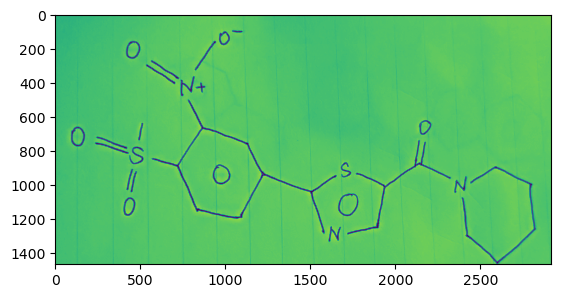

In [25]:
plt.imshow(test_im)
print(test_im.shape)

(321, 640)


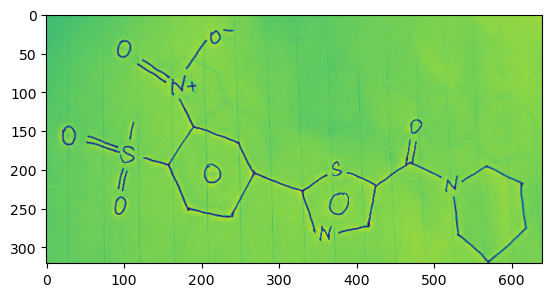

In [26]:
plt.imshow(fea)
print(fea.shape)

In [27]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=patch_size, stride=patch_size, padding=0)

In [28]:
transform2 = Compose([transforms.ToTensor()])

test = transform2(fea).unsqueeze(0)

In [29]:
img2 = conv2d(test)

In [30]:
from einops.einops import rearrange

patch_ten = rearrange(img2, "c p w h -> c (w h) p")

In [31]:
patch_ten.size()

# channels, w*h: sentence size, p: embeddings

torch.Size([1, 800, 256])

In [32]:
import math
from typing import Optional

import pytorch_lightning as pl
import torch
from einops import rearrange, repeat

import torch.nn as nn

class ImgPosEnc(pl.LightningModule):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """
    def __init__(
        self,
        d_model: int = 512,
        temperature: float = 10000.0,
        normalize: bool = False,
        scale: Optional[float] = None,
    ):
        super().__init__()
        assert d_model % 2 == 0
        self.half_d_model = d_model // 2
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x: torch.Tensor, mask: torch.LongTensor) -> torch.Tensor:
        """add image positional encoding to feature

        Parameters
        ----------
        x : torch.Tensor
            [b, h, w, d]
        mask: torch.LongTensor
            [b, h, w]

        Returns
        -------
        torch.Tensor
            [b, h, w, d]
        """
        not_mask = 1 - mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        # not exactly the same as concat two WordPosEnc
        # WordPosEnc: sin(0), cos(0), sin(2), cos(2)
        # ImagePosEnc: sin(0), cos(1), sin(2), cos(3)
        dim_t = torch.arange(self.half_d_model, dtype=torch.float, device=self.device)
        inv_feq = 1.0 / (self.temperature ** (dim_t / self.half_d_model))

        pos_x = torch.einsum("b h w, d -> b h w d", x_embed, inv_feq)
        pos_y = torch.einsum("b h w, d -> b h w d", y_embed, inv_feq)

        pos_x = torch.stack(
            (pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos_y = torch.stack(
            (pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos = torch.cat((pos_x, pos_y), dim=3)

        x = x + pos
        return x


In [ ]:
from typing import List

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import FloatTensor, LongTensor
from torch.nn.modules.transformer import TransformerEncoder, TransformerDecoder

from vocab import vocab, vocab_size

class WordPosEnc(pl.LightningModule):
    def __init__(
        self, d_model: int = 512, max_len: int = 500, temperature: float = 10000.0
    ) -> None:
        super().__init__()
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float)
        dim_t = torch.arange(0, d_model, 2, dtype=torch.float)
        div_term = 1.0 / (temperature ** (dim_t / d_model))

        inv_freq = torch.einsum("i, j -> i j", position, div_term)

        pe[:, 0::2] = inv_freq.sin()
        pe[:, 1::2] = inv_freq.cos()
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """add positional encoding to feature

        Parameters
        ----------
        x : torch.Tensor
            [b, l, d]

        Returns
        -------
        torch.Tensor
            [b, l, d]
        """
        _, seq_len, _ = x.size()
        emb = self.pe[:seq_len, :]
        x = x + emb[None, :, :]
        return x

def _build_transformer_encoder(
    d_model: int,
    nhead: int,
    num_encoder_layers: int,
    dim_feedforward: int,
    dropout: float,
) -> nn.TransformerEncoder:
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    )

    encoder = TransformerEncoder(encoder_layer, num_encoder_layers)
    return encoder

def _build_transformer_decoder(
    d_model: int,
    nhead: int,
    num_decoder_layers: int,
    dim_feedforward: int,
    dropout: float,
) -> nn.TransformerDecoder:
    """build transformer decoder with params
    Parameters
    ----------
    d_model : int
    nhead : int
    num_decoder_layers : int
    dim_feedforward : int
    dropout : float
    Returns
    -------
    nn.TransformerDecoder
    """
    decoder_layer = nn.TransformerDecoderLayer(
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    )

    decoder = TransformerDecoder(decoder_layer, num_decoder_layers)
    return decoder

class Vision(pl.LightningModule):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        dropout: float,
        vocab_size: int,
        image_patch_size: int = 16,
    ):
        super().__init__()
        
        # conv2d, acts like patch reading
        self.conv2d = nn.Conv2d(in_channels=1, out_channels=image_patch_size ** 2, kernel_size=image_patch_size, stride=image_patch_size, padding=0)
        self.bn = nn.BatchNorm2d(image_patch_size ** 2)

        # embedding and encodings
        self.image_pos_enc = ImgPosEnc(d_model, normalize = True)

        self.word_embed = nn.Sequential(
            nn.Embedding(vocab_size, d_model), nn.LayerNorm(d_model)
        )
        self.word_pos_enc = WordPosEnc(d_model=d_model)

        # encoder
        self.encoder = _build_transformer_encoder(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        
        #decoder
        self.decoder = _build_transformer_decoder(
            d_model=d_model,
            nhead=nhead,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        
        # Linear from dim_model to the vocab_size (1024 -> 5xx)
        self.proj = nn.Linear(d_model, vocab_size)

    def _build_attention_mask(self, length):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.full(
            (length, length), fill_value=1, dtype=torch.bool
        )
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    def forward(
        self, src: FloatTensor, src_mask: LongTensor, tgt: LongTensor
    ) -> FloatTensor:
        """generate output for tgt

        Parameters
        ----------
        src : FloatTensor
            [b, t, d]
        tgt : LongTensor

        Returns
        -------
        FloatTensor
            [b, l, vocab_size]
        """
        # conv2d into patch
        src = self.conv2d(src)
        src = self.bn(src)
        src_mask = src_mask[:, 0::16, 0::16]
        
        # rearrange, d = image_patch_size **2 to img_pos_enc
        src = rearrange(src, "b p h w -> b h w p")
        
        # image positional encoding
        src = self.image_pos_enc(src, src_mask)
        
        # flatten to 1d
        src = rearrange(src, "b h w d -> b (h w) d")
                
        # encoder output
        out_enc = self.encoder(
			src = src
		)
        
        out_enc_mask = rearrange(src_mask, "b h w -> b (h w)")
        
        # decoder
        _, l = tgt.size()
        
        tgt_mask = self._build_attention_mask(l)
        tgt_pad_mask = new_tgt == vocab.PAD_IDX

        new_tgt = self.word_embed(new_tgt)  # [b, l, d]
        new_tgt = self.word_pos_enc(new_tgt)  # [b, l, d]

        src = rearrange(out_enc, "b t d -> t b d")
        new_tgt = rearrange(new_tgt, "b l d -> l b d")

        out = self.model(
            tgt=new_tgt,
            memory=src,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=out_enc_mask,
        )

        out = rearrange(out, "l b d -> b l d")
        out = self.proj(out)

        return out